### Предсказание уровней воды на реке Амур

In [1]:
# импортируем все необходимые библиотеки
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pathlib
import pandas as pd

import csv

import os
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import defaultdict
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
import IPython.display
from functools import reduce
from time import time
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

#Зафиксируем псевдослучайность:
rnd_state = 12345

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Путь до папки с данными
path_to_data = 'datasets/'

Определяем период, на который будем предсказывать (в нашем случае это первые 10 дней ноября 2019 года)

In [3]:
predict_period = ['2019-11-01', '2019-11-11'] 
f_day = datetime.strptime(predict_period[0], '%Y-%m-%d') 
l_day = datetime.strptime(predict_period[1], '%Y-%m-%d')
predict_ndays = (l_day - f_day).days

Загрузка данных об уровнях воды на гидропостах.

Датасет daily.pkl - собран из всех файлов {номер_станции}_daily.csv из папки 'datasets/', номер гидропоста записан в отдельной колонке. Колонки приведены к соответствующим форматам, датасет отсортирован по (номеру гидропоста, дате).

In [4]:
daily = pd.read_pickle('processed_data/daily.pkl')

In [5]:
daily.head()

,date,stage_avg,stage_min,stage_max,temp,water_code,station_id
6577,1984-01-01,258.0,258.0,258.0,NaN,NaN,5001
6578,1984-01-02,255.0,255.0,255.0,NaN,NaN,5001
6579,1984-01-03,252.0,252.0,252.0,NaN,NaN,5001
6580,1984-01-04,248.0,248.0,248.0,NaN,NaN,5001
6581,1984-01-05,244.0,244.0,244.0,NaN,NaN,5001


In [6]:
daily = daily.sort_values(by=['station_id','date'])
daily = daily.reset_index(drop=True)

In [7]:
# Выбираем целевые гидрологические посты
station_ids = [6005, 6022, 6027, 5004, 5012, 5024, 5805]
daily = daily[daily['station_id'].isin(station_ids)]

Посмотрим как выглядит ряд для фиксированного station_id

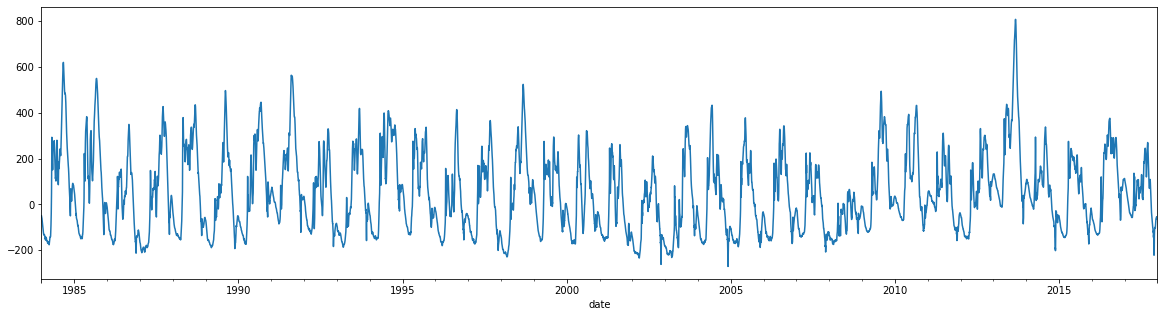

In [8]:
daily = daily.set_index('date')
daily.loc[daily['station_id'] == 5012, 'stage_max'].plot(figsize=(20, 5))
daily = daily.reset_index()

Загрузим и приведем к соответствующим форматам свежие данные по целевым вышкам, которые находятся в файле datasets/hydro2019-20/new_data.csv

In [9]:
# Путь до папки с данными
path_to_data = Path("datasets") 
path_to_data

PosixPath('datasets')

In [10]:
nf = pd.read_csv('hydro_2018-2020/new_data_target.csv', sep=';')

In [11]:
nf.head()

,time,max_level,identifier
0,2020-10-01 00:00:00,799.0,5004
1,2020-10-01 00:00:00,203.0,5805
2,2020-10-01 00:00:00,704.0,5024
3,2020-10-01 00:00:00,521.0,5012
4,2020-10-01 00:00:00,363.0,6005


In [12]:
nf['time'] = pd.to_datetime(nf['time'], format='%Y-%m-%d %H:%M:%S')
nf.columns = ['date', 'stage_max', 'station_id']
nf = nf.sort_values(by=['station_id', 'date'])
nf = nf.set_index('date')
nf = nf[nf.index > '2017-12-31']

Посмотрим на графики новых данных:

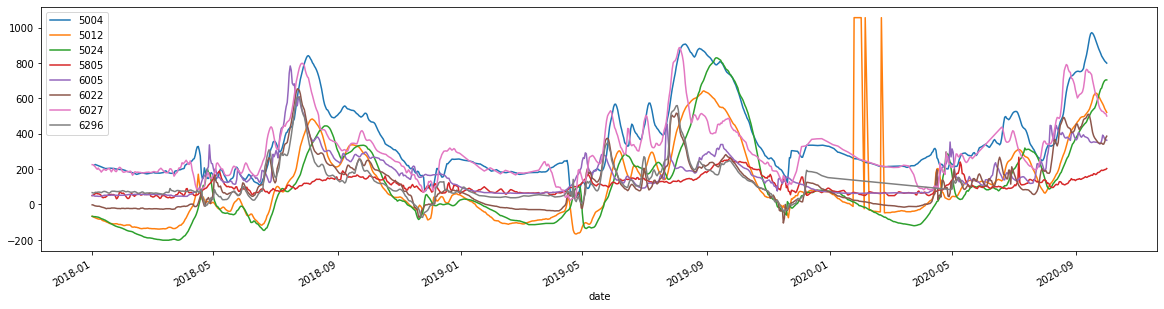

In [13]:
plt.figure(figsize=(20,5))
leg = []
for st in nf.station_id.unique():
    sf = nf[nf['station_id'] == st]
    sf['stage_max'].plot()
    leg.append(st)
plt.legend(leg)

Удалим выбросы у гидрологичского поста с номером 5012

In [14]:
nf.loc[(nf['stage_max'] > nf['stage_max'].\
          quantile(0.99))&(nf['station_id'] == 5012), 'stage_max'] = np.nan

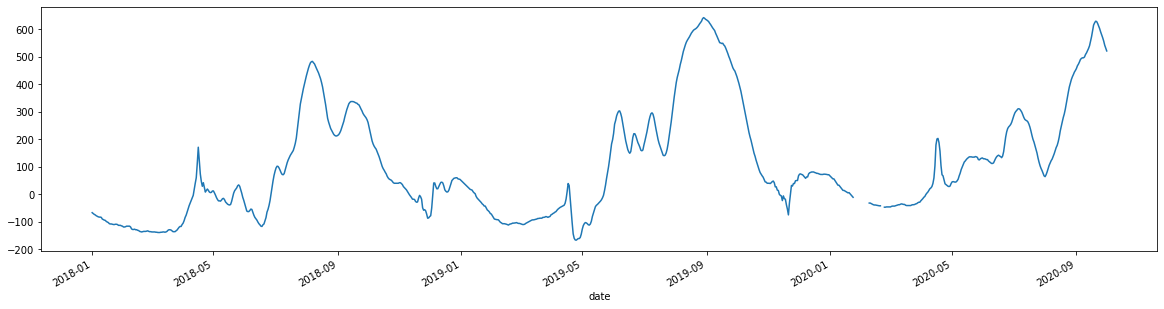

In [15]:
sf = nf[nf['station_id'] == 5012]
sf['stage_max'].plot(figsize=(20,5))

Приведем индексы к такому же виду как в daily и соеденим датасеты

In [16]:
nf = nf.reset_index()
nf = nf.reindex(['date', 'stage_avg', 'stage_min', 'stage_max', 'temp', 'water_code',
       'station_id'], axis=1)
daily = pd.concat([daily, nf], axis=0)
daily = daily.sort_values(by=['station_id', 'date'])

#### Метеоданные

Загрузка метеоданных, соответстующих целевым гидрологическим постам.
Используемый датасет s2m.pkl - (station_to_meteo) - это таблица в которой номеру гидрологического поста поставлен в соответсвие номер ближайшей метеостанции, а так же указано расстояние до неё. Координаты гидрологических постов и метеостанций взяты из http://asunp.meteo.ru/geoits-rest/services/asunp/geo.json

In [17]:
s2m = pd.read_pickle('processed_data/s2m.pkl')
s2m.head()

,meteo_id,dist
station_id,,
5674,4943321,81.846330
5216,4433241,21.467114
6256,5172691,62.347672
5132,4483421,27.216443
5151,4393311,1.111949


In [18]:
pd.read_csv('meteo/4263131.csv', sep=';').head()

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,...,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time
0,GAMOV,4263131,NaN,6,254.0,0,5.0,0,NaN,7.0,...,NaN,NaN,5,NaN,6,1.2,0,76.0,0,2013-04-17 21:00:00
1,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,...,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 18:00:00
2,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,...,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 15:00:00
3,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,...,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 12:00:00
4,GAMOV,4263131,NaN,6,233.0,0,7.0,0,NaN,10.0,...,NaN,NaN,5,NaN,6,3.4,0,75.0,0,2013-04-17 09:00:00


In [19]:
# Вспомогательная функция для соединения идентичных датафреймов 
def weary_append(x,y):
    if x is not None:
        if any([a for a in list(x.columns) if a not in y.columns]) or any([a for a in list(y.columns) if a not in x.columns]):
            raise ValueError()
        else:
            return x.append(y)
    else:
        return y

Считываем файлы с метеоданными, соответствующие целевым гидрологическим постам. Номер метеостанции записываем в колонку meteo_id, а номер гидрологического поста в station_id

In [20]:
meteo = None
for s, m in s2m.loc[station_ids][['meteo_id']].iterrows():
    m = m.values[0]
    df = pd.read_csv('meteo/{}.csv'.format(m), sep=';').rename({'station_id': 
                                                                                        'meteo_id'}, axis=1)
    df['datetime'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    df['date'] = df['datetime'].apply(lambda x: x.date())
    df['station_id'] = s
    meteo = weary_append(meteo, df)

Согласно описанию данных (а именно файл Время_85.docx) данные до '1993-1-1' записывались по GMT+3, поэтому переведем их к Гринвичу

In [21]:
meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'] = \
    meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'].apply(lambda x: x - timedelta(hours=3))

Усреднение температурных признаков по (времени суток, дате)

In [22]:
meteo = meteo.set_index('datetime')
meteo[meteo.index.month==3].groupby(meteo[meteo.index.month==3].index.hour)['temperature_air'].mean()

datetime
0    -10.401762
3     -5.039252
6     -2.809799
9     -3.957306
12    -7.727059
15   -10.338852
18   -12.013950
21   -13.245664
Name: temperature_air, dtype: float64

In [23]:
meteo['night'] = (meteo.index.hour > 14) | (meteo.index.hour < 2)
dmeteo = meteo.groupby(['station_id', 'date', 'night'])[['temperature_air', 
                                                    'temperature_ground']].mean().reset_index(level=2)
dmeteo = dmeteo.pivot(columns='night')
ncols = []
for col in dmeteo.columns:
    if col[1]:
        prefix = 'night_'
    else:
        prefix = 'day_'
    ncols.append(prefix + col[0])
dmeteo.columns = ncols

# Получили датасет со средней ночной и дневной температурой воздуха 
# и почвы за каждый день.

dmeteo.head()

day_temperature_air  night_temperature_air  \
station_id date                                                     
5004       1985-01-01              -17.900                -24.400   
           1985-01-02              -16.775                -26.250   
           1985-01-03              -18.975                -24.650   
           1985-01-04              -19.150                -26.050   
           1985-01-05              -21.200                -27.675   

                       day_temperature_ground  night_temperature_ground  
station_id date                                                          
5004       1985-01-01                 -19.950                   -27.275  
           1985-01-02                 -19.725                   -29.375  
           1985-01-03                 -19.900                   -26.900  
           1985-01-04                 -19.900                   -28.175  
           1985-01-05                 -21.775                   -28.175

Значения влажности воздуха беру среднее за сутки, а кол-во осадков - максимальное

In [24]:
dmeteo[['humidity', 'precipitation_amount']] = \
meteo.groupby(['station_id', 'date'])[['humidity', 'precipitation_amount']].agg({'humidity': 'mean', 
                                                                                 'precipitation_amount': 'max'})

Реализуем функцию, которая будет аггрегировать метео признаки по заданному количеству дней, заданной функцией и сдвигать на заданное число дней

In [25]:
def agg_meteo(df, 
              columns = ['day_temperature_air', 'night_temperature_air', 'day_temperature_ground', 
                         'night_temperature_ground', 'humidity','precipitation_amount'],
              agg_days = [15, 15, 15, 15, 10, 60],
              agg_funcs = ['mean', 'mean', 'mean', 'mean', 'sum', 'sum'],
              shift = [10, 10, 10, 10, 10, 10]):
    res = pd.DataFrame(index=df.index)
    names = []
    for c, d, f, s in zip(columns, agg_days, agg_funcs, shift):
        name = '{}_{}_{}'.format(c, d, s)
        res[name] = df[c].rolling(d, min_periods=1).agg(f).shift(s)
        names.append('{}_{}_{}'.format(c, d, s))
    return res.reset_index(), names

In [26]:
agg, meteo_feats = agg_meteo(dmeteo)
agg['date'] = pd.to_datetime(agg['date'])

Присоединяем метеоданные к посуточным замерам уровней

In [27]:
daily = daily.merge(agg, on=['station_id', 'date'], how='left')
daily.shape

(93596, 13)

Создаем "календарные" признаки

In [28]:
daily = daily.set_index('date')
daily['year'] = daily.index.year
daily['month'] = daily.index.month
daily['day'] = daily.index.day
daily['doy'] = daily.index.dayofyear
daily = daily.reset_index()

По графикам можно наблюдать некую годовую сезонность в значениях уровня воды. Поэтому, могут оказаться полезными признаки: значения уровня воды последние годы в предсказываемые даты.

In [29]:
# Вспомогательная функция, прибавляющая года в кол-ву years к дате d
def add_years(d, years):
    try:
        return d.replace(year = d.year + years)
    except ValueError:
        return d + (datetime(d.year + years, 1, 1) - datetime(d.year, 1, 1))

In [30]:
# Цикл по количеству рассматриваемых лет
past = []
for y in range(1, 6):
    daily['ndate'] = daily['date'].apply(lambda x: add_years(x, y))
    hf = daily[['ndate', 'station_id', 'stage_max']].rename({'ndate': 'date', 'stage_max': 
                                                             'past_{}'.format(y)}, axis=1)
    
#     Удаление дубликатов, появляющихся из-за 29 февраля
    hf = hf.set_index(['station_id', 'date']) 
    hf = hf[~hf.index.duplicated(keep='first')]
    hf = hf.reset_index()
    
    daily = daily.merge(hf, on=['station_id', 'date'], how='left').drop('ndate', axis=1)
#     Цикл по датам целевого периода
    for i in range(predict_ndays+1):
        daily['past_{}_{}'.format(y, i)] = daily['past_{}'.format(y)].shift(-i)
        past.append('past_{}_{}'.format(y, i))
    daily.drop('past_{}'.format(y), axis=1, inplace=True)

Осталось добавить признаки временного ряда, то есть значения таргета за ndays предыдущих дней. Но, так как в исходных датасетах встречаются пропущенные даты, их надо сначала заполнить NaN'ми. Для этого воспользуемся методом .date_range и .reindex

In [31]:
daily = daily.set_index(['station_id', 'date'])
new_index = pd.MultiIndex.from_product([daily.index.get_level_values(0).unique(), 
                                        pd.date_range('1984-1-1', '2020-10-01')])
daily = daily.reindex(new_index)

Создание признаков временного ряда

In [32]:
ndays = 20

In [33]:
daily['target'] = daily['stage_max']
ts = []
for i in range(ndays, 0, -1):
    daily['ts_{}'.format(i)] = daily.groupby('station_id')['stage_max'].shift(i)
    ts.append('ts_{}'.format(i))
# daily.drop('stage_max', axis=1, inplace=True)

Выкидываем строки в которых таргет NaN

In [34]:
daily = daily[daily['target'].notna()]

#### Обучение

Для кросс-валидации использум деление выборки на train: до f_day i-го года; test: predictperiod i-го года, где i пробегает 5 последних лет, имеющихся в тренировочной выборке.

In [35]:
# Генератор индексов для кросс-валидации
def train_test_fold(df, f_day, l_day):
    for year in [f_day.year - 5 + i for i in range(5)]:
        f = '{}-{}'.format(year, datetime.strftime(f_day, '%m-%d'))
        l = '{}-{}'.format(year, datetime.strftime(l_day, '%m-%d'))
        yield df.index[df.index < f], df.index[(df.index>=f)&(df.index<l)]

Реализация функции пошагового предсказания. На вход подается:

1. model - обученная модель
2. ts_data - значения таргета за последние ndays тренировочной выборки
3. test_data - дополнительные признаки, в тестовый период (признаки не должны зависеть от значений, которые могут быть получены только в тестовый период. Поэтому, например, все погодные признаки сдвинуты на _predictndays вперед)
4. features - список названий доп. признаков
5. n - количество дней, на которые строится предказание

In [36]:
def steps_predict(model, ts_data, test_data, features, n):
    isfeat = len(features) > 0
    test_features = test_data[features].values
    if isfeat:
        data = np.r_[test_features[0], ts_data].reshape(1,-1)
    else:
        data = ts_data.reshape(1,-1)
    predict = []
    predict.append(model.predict(data)[0])

    for i in range(1, n):
        ts_data = np.r_[ts_data[1:], predict[i-1]]
        if isfeat:
            data = np.r_[test_features[i], ts_data].reshape(1,-1)
        else:
            data = ts_data.reshape(1,-1)
        predict.append(model.predict(data)[0])
    return np.array(predict)

In [37]:
def metrics(true, pred, station_id, printit=False):
    mae = np.mean(np.abs(pred - true))   
    if printit:
        print("MAE: {}".format(mae))
    return mae

In [38]:
def plot_predict(true, pred, station_id=None):
    plt.figure(figsize=(20, 5))
    plt.plot(true)
    plt.plot(pred)
    leg = ['true values', 'predict values']
    
    plt.legend(leg)
    if station_id is not None:
        plt.title(station_id)
    plt.show()

Реализация собственной функции кросс-валидации модели. Разбиения строятся с помощью train_test_fold(df, f_day, l_day). В качестве ошибки на валидационной выборке будем использовать метрику $MAE$

In [39]:
def cross_val(model, dataset, gen, target_name, features, lag, predict_ndays, 
              station_id, ts, eval_metric='wmae2', plotit=False):
    mae_list = []
    rmse_list = []
    wmae_list = []
    wmae2_list = []
    for i in range(5):
        train_idx, test_idx = next(gen)
        X_train = dataset.loc[train_idx].sort_index()
        X_test = dataset.loc[test_idx].sort_index()

        X = X_train[features + ts].copy()
        y = X_train[target_name]
        
        if eval_metric == 'wmae2':
            eval_metr = lambda x, y: ['wmae2', comp_wmae2(x, y, station_id), True]
        else:
            eval_metr = eval_metric
        model.fit(X, y)
        
        ts_data = X_train[target_name].values[-lag:]
        predict = steps_predict(model, ts_data, X_test, features, predict_ndays)
        if target_name == 'delta':
            predict = X_test['mean_by_date'].values + predict
        true = X_test[target_name].values
        mae = metrics(true, predict,station_id)
        mae_list.append(mae)

        if plotit:
            plot_predict(true, predict, station_id=station_id)
    res_table = pd.DataFrame([mae_list, rmse_list, wmae2_list], 
                        index=['MAE', 'RMSE', 'WMAE2'],
                        columns = ['fold{}'.format(i) for i in range(1, 6)])
    return res_table

Напишем функцию, которая на вход будет подавать модель и датасеты, будет возвращать время обучения, время предсказания и mae.

In [40]:
def model_eval(model, X_train, y_train, X_test, y_test):
    
    start = time()   
    model.fit(X_train, y_train)
    training_time = time() - start
    
    start_1 = time()   
    target_pred = model.predict(X_test)
    predict_time = time() - start_1

    return training_time, predict_time

Посмотрим на степень влияния дополнительных признаков на результат работы модели. 

Для этого воспользуемся библиотекой shap https://shap.readthedocs.io/en/latest/index.html

In [41]:
all_features = meteo_feats + ['year', 'month', 'doy'] + past
station_id = 5012
features = all_features

sf = daily.loc[station_id]
model_lgb = lgb.LGBMRegressor(random_state=12345)
X_train = sf.loc[sf.index < f_day, features]
y_train = sf.loc[sf.index < f_day, 'target']
X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
model_lgb.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [42]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [43]:
import shap
X_importance = X_train
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_importance)

In [44]:
X_train

,day_temperature_air_15_10,night_temperature_air_15_10,day_temperature_ground_15_10,night_temperature_ground_15_10,humidity_10_10,precipitation_amount_60_10,year,month,doy,past_1_0,...,past_5_1,past_5_2,past_5_3,past_5_4,past_5_5,past_5_6,past_5_7,past_5_8,past_5_9,past_5_10
1984-01-01,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-02,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-03,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-04,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,300.0,40.0,...,-63.0,-67.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0
2019-10-28,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,301.0,40.0,...,-67.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0
2019-10-29,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,302.0,40.0,...,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0,-94.0
2019-10-30,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,303.0,40.0,...,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0,-94.0,-93.0


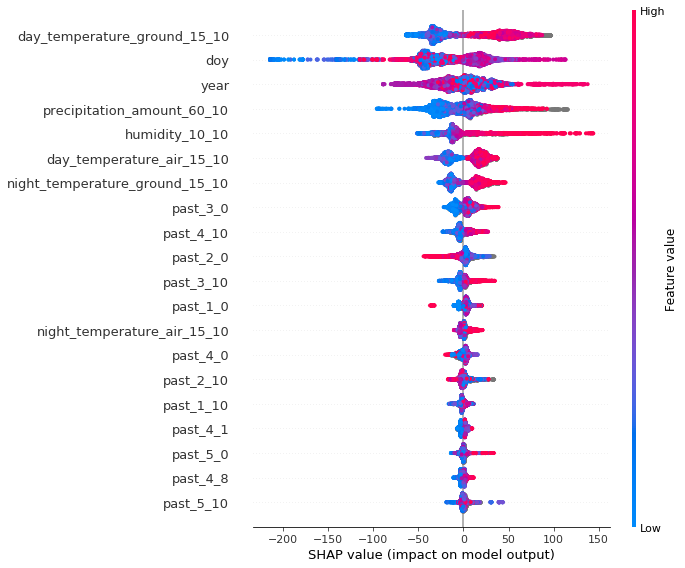

In [45]:
shap.summary_plot(shap_values, X_importance)

Из графика видно, что метеопризнаки довольно сильно влияют на целевое значение. Например, как и ожидалось, признак precipitation_amount_60_10 - накопленные осадки за 60 дней, 10 дней назад при больших значениях дает положительный вклад в целевое значение, а при малых - отрицательный. Тот же эффект виден для humidity_10_10 - накопленная влажность воздуха за 10 дней, 10 дней назад.

In [46]:
predict = model_lgb.predict(X_test)
true = y_test.values
metrics(true, predict, station_id)

32.75925779577402

### Создание и обучение моделей

Построим 3 модели регрессии: Линейная регрессия, Случайный лес, Дерево Решений.

Разобьем данные на три выборки: тренировочную, валидационную и тестовую.

In [47]:
train, valid = train_test_split(sf, test_size=0.4, shuffle=False, random_state=rnd_state)
valid, test = train_test_split(valid, test_size=0.5, shuffle=False, random_state=rnd_state)

train.shape, valid.shape, test.shape

((8014, 91), (2671, 91), (2672, 91))

In [48]:
all_features = meteo_feats + ['year', 'month', 'doy'] + past
station_id = 5012
features = all_features

sf = daily.loc[station_id].fillna(0)
X_train = sf.loc[sf.index < f_day, features]
y_train = sf.loc[sf.index < f_day, 'target']
X_valid = sf.loc[sf.index < f_day, features]
y_valid = sf.loc[sf.index < f_day, 'target']
X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']

#### Линейная регрессия¶

In [49]:
model_lr = LinearRegression()

start = time() 
model_lr.fit(X_train, y_train)

training_time_lr = model_eval(model_lr, X_train, y_train, X_test, y_test)
predict_lr = pd.DataFrame(model_lr.predict(X_valid))
mae_lr = mean_absolute_error(y_valid, predict_lr) 

print("MAE LinearRegression:", mae_lr)
print("Время обучения LinearRegression:", training_time_lr)

MAE LinearRegression: 81.54974980834969
Время обучения LinearRegression: (0.018886804580688477, 0.0007581710815429688)


#### Дерево решений

In [50]:
for max_depth in range (4,21,2):
    model_dtr = DecisionTreeRegressor(max_depth=max_depth, random_state=12345)
    start_time = time()
    model_dtr.fit(X_train, y_train)
    
    training_time_dtr = model_eval(model_dtr, X_train, y_train, X_test, y_test)
    predict_dtr = model_dtr.predict(X_valid)
    mae_dtr = mean_absolute_error(y_valid, predict_dtr)

    print('max_depth=', max_depth, ':', mae_dtr)
    print("Время обучения DecisionTreeRegressor:", training_time_dtr)

max_depth= 4 : 79.35176334652316
Время обучения DecisionTreeRegressor: (0.18963408470153809, 0.0019381046295166016)
max_depth= 6 : 66.05072278560345
Время обучения DecisionTreeRegressor: (0.28661608695983887, 0.0007691383361816406)
max_depth= 8 : 50.678137857174185
Время обучения DecisionTreeRegressor: (0.38246703147888184, 0.0008728504180908203)
max_depth= 10 : 36.37225511351996
Время обучения DecisionTreeRegressor: (0.4754519462585449, 0.0008671283721923828)
max_depth= 12 : 25.14562097328005
Время обучения DecisionTreeRegressor: (0.5586409568786621, 0.000865936279296875)
max_depth= 14 : 16.096759941755693
Время обучения DecisionTreeRegressor: (0.6351990699768066, 0.0007638931274414062)
max_depth= 16 : 9.512668437786049
Время обучения DecisionTreeRegressor: (0.6894869804382324, 0.0008819103240966797)
max_depth= 18 : 4.879420217602128
Время обучения DecisionTreeRegressor: (0.7263538837432861, 0.0008661746978759766)
max_depth= 20 : 2.373411657983911
Время обучения DecisionTreeRegressor:

#### Случайный лес

In [51]:
for i in range(1, 11):
    
    model_random = RandomForestRegressor(n_estimators=i, random_state=rnd_state)
    start_time = time()
    model_random.fit(X_train, y_train)
    
    training_time_random = model_eval(model_random, X_train, y_train, X_test, y_test)
    
    predict_random = pd.DataFrame(model_random.predict(X_valid))
    mae_random = mean_absolute_error(y_valid, predict_random)
    
    print('n_estimators=', i, ':', mae_random)
    print("Время обучения RandomForestRegressor:", training_time_random)

n_estimators= 1 : 8.767812045611082
Время обучения RandomForestRegressor: (0.531796932220459, 0.0010941028594970703)
n_estimators= 2 : 8.183783576949567
Время обучения RandomForestRegressor: (0.9777190685272217, 0.0012888908386230469)
n_estimators= 3 : 7.629983928981403
Время обучения RandomForestRegressor: (1.4734039306640625, 0.001344919204711914)
n_estimators= 4 : 7.481288742634116
Время обучения RandomForestRegressor: (1.9894671440124512, 0.001277923583984375)
n_estimators= 5 : 7.325078441876482
Время обучения RandomForestRegressor: (2.4416162967681885, 0.0014019012451171875)
n_estimators= 6 : 7.080265809545676
Время обучения RandomForestRegressor: (2.875014305114746, 0.0014069080352783203)
n_estimators= 7 : 6.931834829286425
Время обучения RandomForestRegressor: (3.4224331378936768, 0.0016498565673828125)
n_estimators= 8 : 6.852070100252544
Время обучения RandomForestRegressor: (3.8404040336608887, 0.001519918441772461)
n_estimators= 9 : 6.652687431443076
Время обучения RandomFore

#### Сравним модели

In [52]:
sf_time = pd.Series({'LinearRegression': training_time_lr,
              'DecisionTreeRegressor': training_time_dtr,
              'RandomForestRegressor': training_time_random})
                          
sf_time

LinearRegression         (0.018886804580688477, 0.0007581710815429688)
DecisionTreeRegressor      (0.7741799354553223, 0.0008630752563476562)
RandomForestRegressor        (4.87220025062561, 0.0018188953399658203)
dtype: object

In [53]:
final_mae = pd.Series({'LinearRegression': mae_lr,
              'DecisionTreeRegressor': mae_dtr,
              'RandomForestRegressor': mae_random}) 

final_mae

LinearRegression         81.549750
DecisionTreeRegressor     2.373412
RandomForestRegressor     6.488536
dtype: float64

Наиболее подходящей моделью является CatBoost, у которой наименьшее значение метрики MAE: 2.373412

**Проверим модель на тестовой выборке:**

In [54]:
model_dtr = DecisionTreeRegressor(max_depth=12, random_state=12345)
start_time = time()
model_dtr.fit(X_train, y_train)
    
training_time_dtr = model_eval(model_dtr, X_train, y_train, X_test, y_test)
predict_dtr = model_dtr.predict(X_test)
mae_dtr = mean_absolute_error(y_test, predict_dtr)

print('MAE_dtr:', mae_dtr)
print("Время обучения RandomForestRegressor:", training_time_dtr)

MAE_dtr: 16.133333333333333
Время обучения RandomForestRegressor: (0.5610229969024658, 0.0007658004760742188)


#### График важности факторов

In [55]:
X_importance = X_train
explainer = shap.TreeExplainer(model_dtr)
shap_values = explainer.shap_values(X_importance)

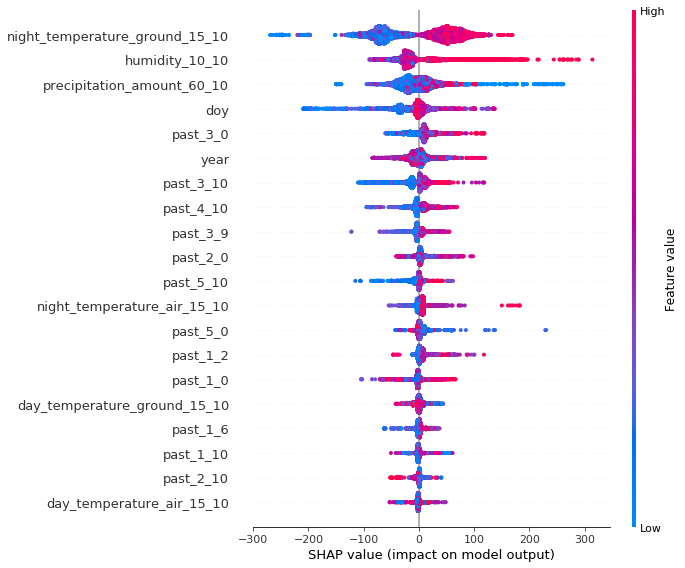

In [56]:
shap.summary_plot(shap_values, X_importance)

#### Проверка модели на адекватность

In [57]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
predict_dummy = dummy.predict(X_test)
mae_dummy = mean_absolute_error(y_test, predict_dummy)
print('MAE на cлучайной выборке:', mae_dummy)

MAE на cлучайной выборке: 14.583439197979647


Рассмотрев три модели, можно сделать вывод, что наилучшей является из трех представленных - **"Модель Случайного леса"**.

Из графика важности факторов можно отметить, что при данной модели факторы ведут себя также как при раннее предложенной модели LGB. 

In [58]:
def grid_search(df, params, features, ndays, predict_ndays, station_id, ts):
    best_metric = 500
    for ne in params['max_depth']:
        for lr in params['learning_rate']:
            for nl in params['num_leaves']:
                model_dtr = DecisionTreeRegressor(max_depth=max_depth, random_state=12345)
                
    return params

In [59]:
grid_params = {
    'max_depth': [4, 21, 2],
    'learning_rate': [0.05, 0.1, 0.12],
    'num_leaves': [27, 31, 37]
}

In [60]:
model_params = {}
for station_id in station_ids:
    sf = daily.loc[station_id].copy()
    features = all_features
    model_params[station_id] = grid_search(sf, grid_params, features, ndays, predict_ndays, station_id, ts)

#### Результаты

В следующей ячейки собирается таблица с результатами предсказаний sample_submission.

Построены графики с предсказанными и настоящими значениями и выведено значение метрики для каждого гидрологического поста.

6005  MAE:  32.07584670231729


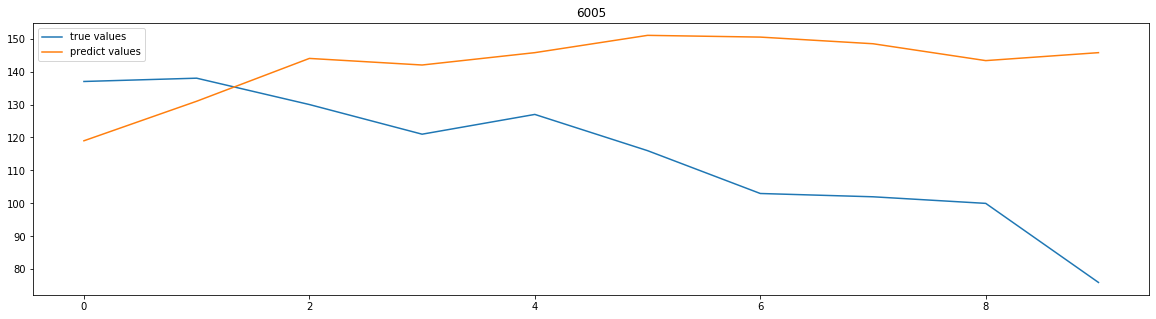

6022  MAE:  48.75


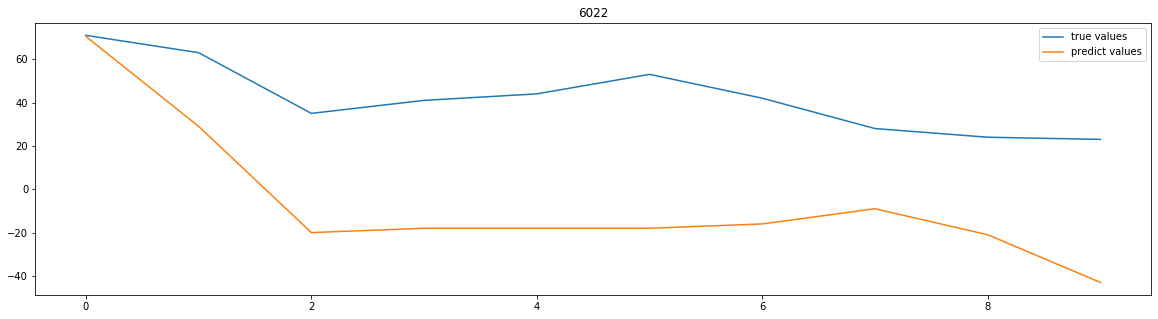

6027  MAE:  36.466666666666654


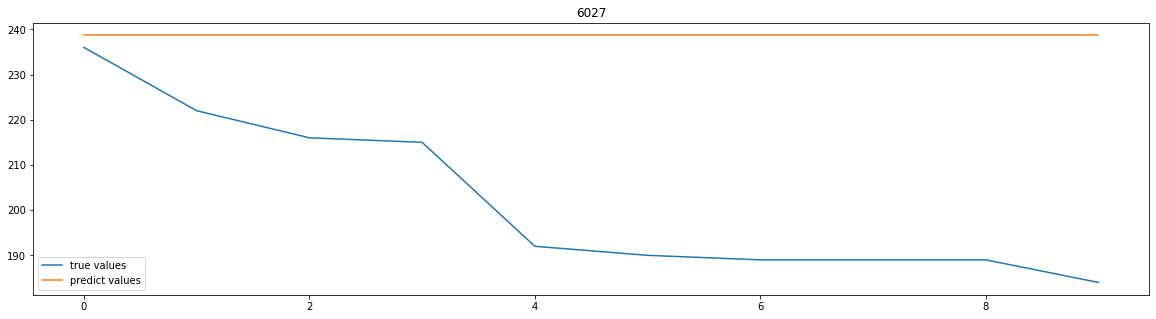

5004  MAE:  15.997435897435897


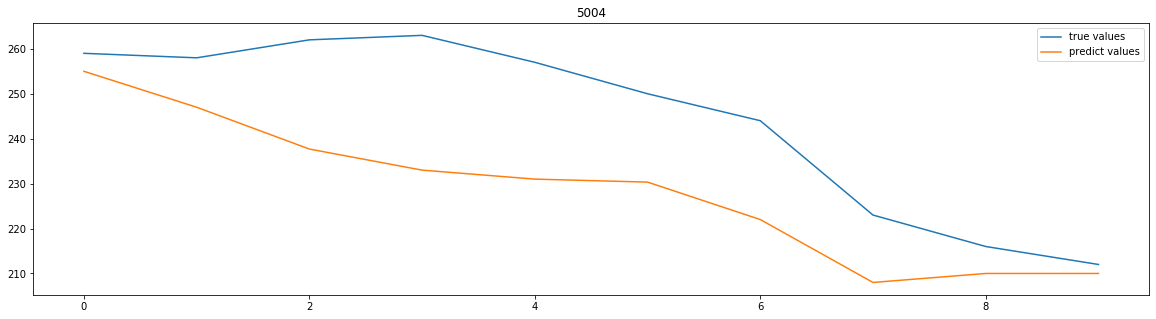

5012  MAE:  47.58695652173913


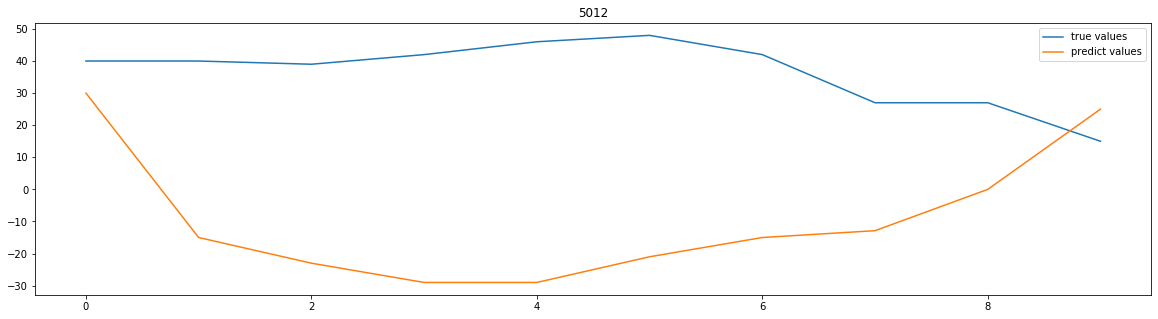

5024  MAE:  115.0


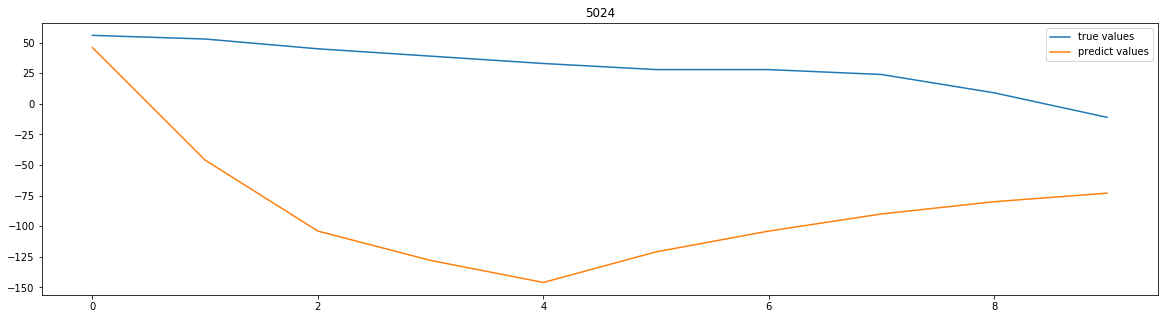

5805  MAE:  18.366078431372546


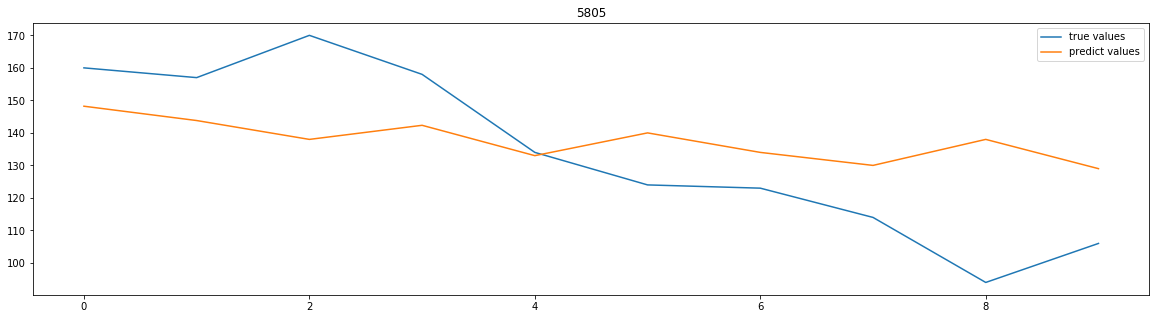

In [61]:
sample_submission = pd.DataFrame(index=pd.date_range(f_day, l_day - timedelta(1)))
dtr_metrics = {}
for key in model_params:
    station_id = int(key)
    params = model_params[key]
    model_dtr = DecisionTreeRegressor(max_depth=max_depth, random_state=12345)
    sf = daily.loc[int(key)].fillna(0)
    X_train = sf.loc[sf.index < f_day, features + ts]
    y_train = sf.loc[sf.index < f_day, 'target']
    X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
    y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
    model_dtr.fit(X_train, y_train)
    ts_data = y_train.values[-ndays:]
    predict = steps_predict(model_dtr, ts_data, X_test, features, predict_ndays)
    sample_submission[key] = predict # запись результата в таблицу
    mae = metrics(y_test.values, predict, station_id)
    dtr_metrics[station_id] = [mae]
    print(station_id, ' MAE: ', mae)
    plot_predict(y_test.values, predict, station_id)

In [62]:
sample_submission

,6005,6022,6027,5004,5012,5024,5805
2019-11-01,119.000000,70.5,238.666667,255.000000,30.000000,46.0,148.205882
2019-11-02,131.000000,29.0,238.666667,247.000000,-15.000000,-46.0,143.800000
2019-11-03,144.000000,-20.0,238.666667,237.692308,-23.000000,-104.0,138.000000
2019-11-04,142.000000,-18.0,238.666667,233.000000,-29.000000,-128.0,142.333333
2019-11-05,145.750000,-18.0,238.666667,231.000000,-29.000000,-146.0,133.000000
2019-11-06,151.000000,-18.0,238.666667,230.333333,-21.000000,-121.0,140.000000
2019-11-07,150.470588,-16.0,238.666667,222.000000,-15.000000,-104.0,134.000000
2019-11-08,148.454545,-9.0,238.666667,208.000000,-12.869565,-90.0,130.000000
2019-11-09,143.333333,-21.0,238.666667,210.000000,0.000000,-80.0,138.000000
2019-11-10,145.750000,-43.0,238.666667,210.000000,25.000000,-73.0,129.000000
